In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

In [ ]:
data=pd.read_csv('smartgrid.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [ ]:
# Data Description
print("Data Description:\n", data.describe())
print("\nMissing Values:\n", data.isnull().sum())

Data Description:
                tau1          tau2          tau3          tau4            p1  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       5.250000      5.250001      5.250004      5.249997      3.750000   
std        2.742548      2.742549      2.742549      2.742556      0.752160   
min        0.500793      0.500141      0.500788      0.500473      1.582590   
25%        2.874892      2.875140      2.875522      2.874950      3.218300   
50%        5.250004      5.249981      5.249979      5.249734      3.751025   
75%        7.624690      7.624893      7.624948      7.624838      4.282420   
max        9.999469      9.999837      9.999450      9.999443      5.864418   

                 p2            p3            p4            g1            g2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -1.250000     -1.250000     -1.250000      0.525000      0.525000   
std        0.433035      0.43303

In [ ]:
# Classes Imbalanced Distributions
print("\nClass Distribution:\n", data['stabf'].value_counts())
X = data.drop('stabf', axis=1)
y = data['stabf']


Class Distribution:
 stabf
unstable    6380
stable      3620
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load dataset
data = pd.read_csv('smartgrid.csv')
X = data.drop('stabf', axis=1)
y = data['stabf']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # stable = 0, unstable = 1

# Step 1: SMOTE BEFORE splitting
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y_encoded)

print("Label distribution after SMOTE:", pd.Series(y_balanced).value_counts(normalize=True))

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)


Label distribution after SMOTE: 1    0.5
0    0.5
Name: proportion, dtype: float64



Class Distribution:
stabf
unstable    6380
stable      6380
Name: count, dtype: int64


<ipython-input-6-a11dad6bb0fa>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


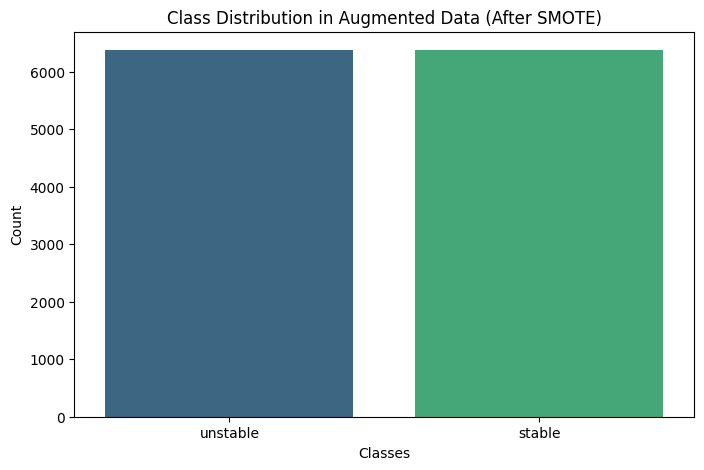

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#DataFrame with balanced y values
augdata = pd.DataFrame(X_balanced, columns=X.columns)
augdata['stabf'] = le.inverse_transform(y_balanced)  # convert back to original labels for clarity

# Class distribution
print("\nClass Distribution:")
class_counts = augdata['stabf'].value_counts()
print(class_counts)

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution in Augmented Data (After SMOTE)")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()



Correlation Matrix:
          tau1      tau2      tau3      tau4        p1        p2        p3  \
tau1  1.000000  0.007154 -0.015827 -0.023696  0.031943 -0.018466 -0.019703   
tau2  0.007154  1.000000 -0.001017 -0.016489 -0.005244  0.006027  0.008907   
tau3 -0.015827 -0.001017  1.000000 -0.004134  0.011138 -0.000525 -0.003556   
tau4 -0.023696 -0.016489 -0.004134  1.000000 -0.008679  0.022478  0.007731   
p1    0.031943 -0.005244  0.011138 -0.008679  1.000000 -0.573673 -0.584861   
p2   -0.018466  0.006027 -0.000525  0.022478 -0.573673  1.000000  0.002110   
p3   -0.019703  0.008907 -0.003556  0.007731 -0.584861  0.002110  1.000000   
p4   -0.017401 -0.005819 -0.015291 -0.015083 -0.581174 -0.002118  0.013305   
g1   -0.024110  0.017907  0.000552  0.002890  0.001235  0.013697 -0.005323   
g2    0.026163 -0.020199  0.022383  0.020447  0.014554 -0.020375 -0.005920   
g3    0.022642  0.040230 -0.016266  0.005453  0.004002  0.006263 -0.005534   
g4    0.024423  0.003904  0.006900 -0.03781

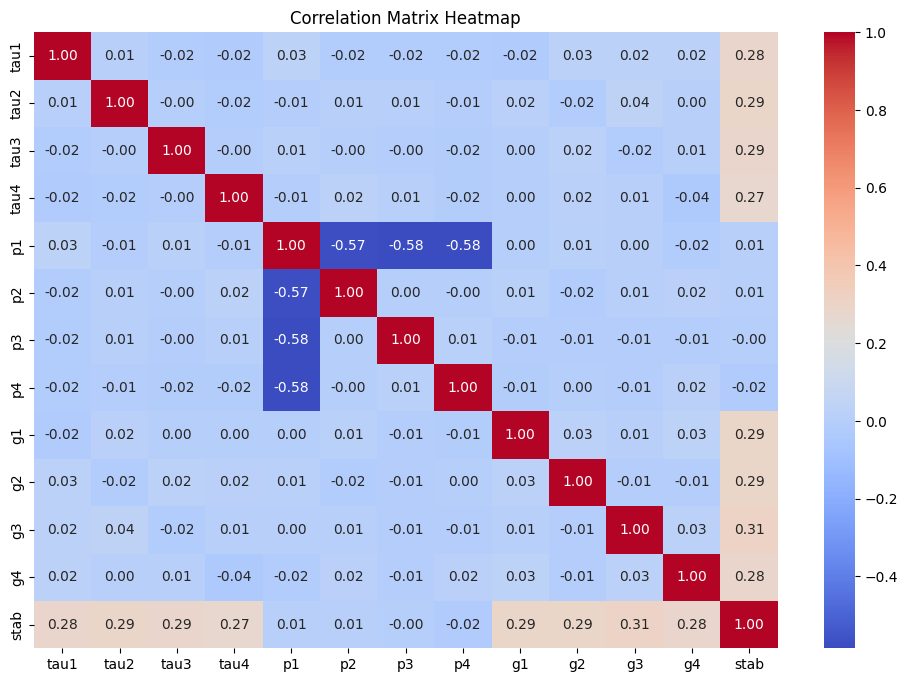

In [ ]:
# Correlation Analysis
# Remove the target column 'stabf' (non-numeric)
numerical_data = augdata.drop('stabf', axis=1)

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

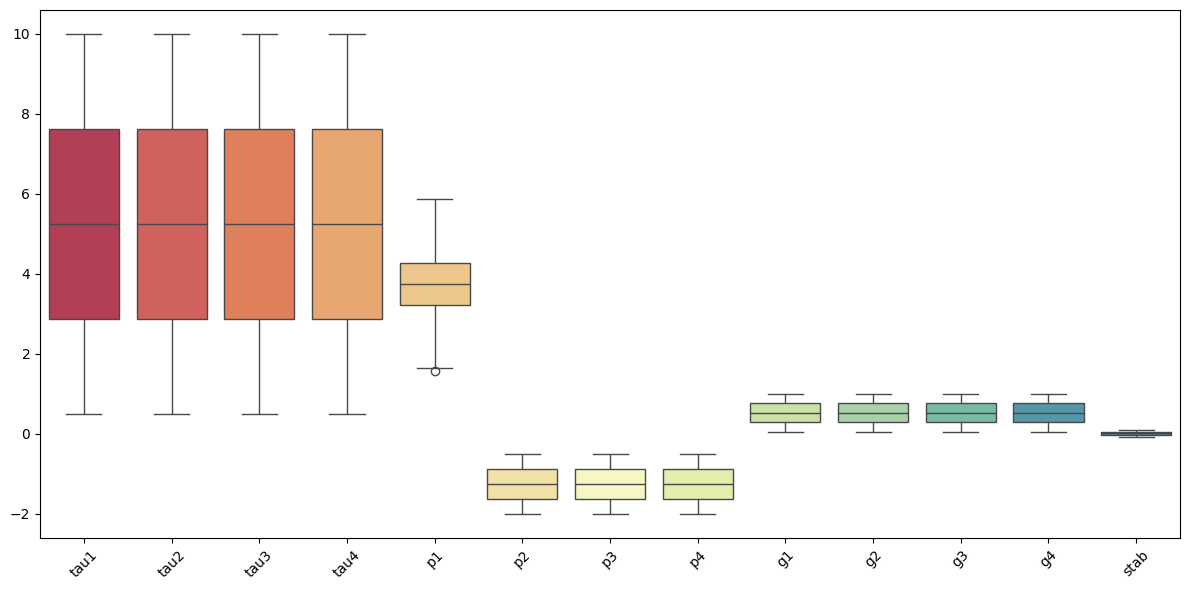

In [ ]:
columns_to_plot = ['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab']
plt.figure(figsize=(12, 6))
sns.boxplot(data[columns_to_plot], palette='Spectral')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


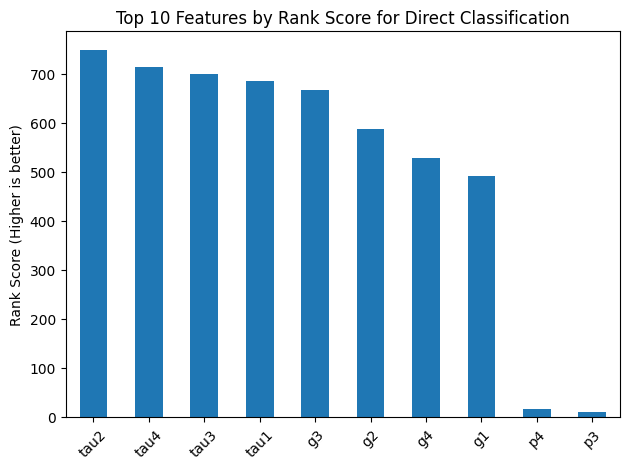

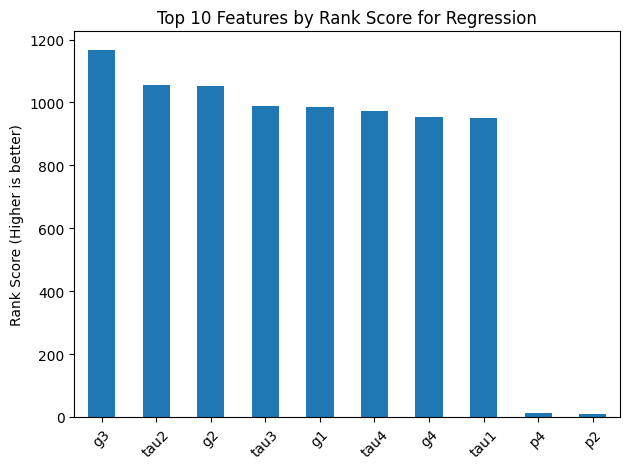

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

X_class = data.drop(['stabf', 'stab'], axis=1)
y_class = LabelEncoder().fit_transform(data['stabf'])

feature_names = X_class.columns.tolist()
rank_scores_cls = pd.DataFrame(0, index=feature_names, columns=['score'])

# 1. SelectKBest (ANOVA)
skb = SelectKBest(score_func=f_classif, k='all')
skb.fit(X_class, y_class)
rank_scores_cls['score'] += skb.scores_

# 2. RFE with Logistic Regression
rfe = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe.fit(X_class, y_class)
rank_scores_cls['score'] += rfe.ranking_.max() + 1 - rfe.ranking_

# 3. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_class, y_class)
rank_scores_cls['score'] += rf.feature_importances_ * 100

# 4. L1-based Logistic Regression
l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
l1.fit(StandardScaler().fit_transform(X_class), y_class)
rank_scores_cls['score'] += np.abs(l1.coef_[0]) * 100

# Plot Top 10 - Classification
rank_scores_cls = rank_scores_cls.sort_values('score', ascending=False)
rank_scores_cls.head(10).plot(kind='bar', legend=False)
plt.title('Top 10 Features by Rank Score for Direct Classification')
plt.ylabel('Rank Score (Higher is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Regression (numerical stability index) ---
if data['stab'].dtype == 'object':
    print("Column 'stab' contains non-numeric values; regression skipped.")
else:
    X_reg = data.drop(['stab', 'stabf'], axis=1)
    y_reg = data['stab']

    rank_scores_reg = pd.DataFrame(0, index=X_reg.columns, columns=['score'])

    # 1. SelectKBest for regression
    skb = SelectKBest(score_func=f_regression, k='all')
    skb.fit(X_reg, y_reg)
    rank_scores_reg['score'] += skb.scores_

    # 2. Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_reg, y_reg)
    rank_scores_reg['score'] += rf.feature_importances_ * 1000

    # 3. PCA component contributions
    pca = PCA(n_components=5)
    X_scaled = StandardScaler().fit_transform(X_reg)
    pca.fit(X_scaled)
    contributions = np.sum(np.abs(pca.components_), axis=0)
    rank_scores_reg['score'] += contributions

    # Plot Top 10 - Regression
    rank_scores_reg = rank_scores_reg.sort_values('score', ascending=False)
    rank_scores_reg.head(10).plot(kind='bar', legend=False)
    plt.title('Top 10 Features by Rank Score for Regression')
    plt.ylabel('Rank Score (Higher is better)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


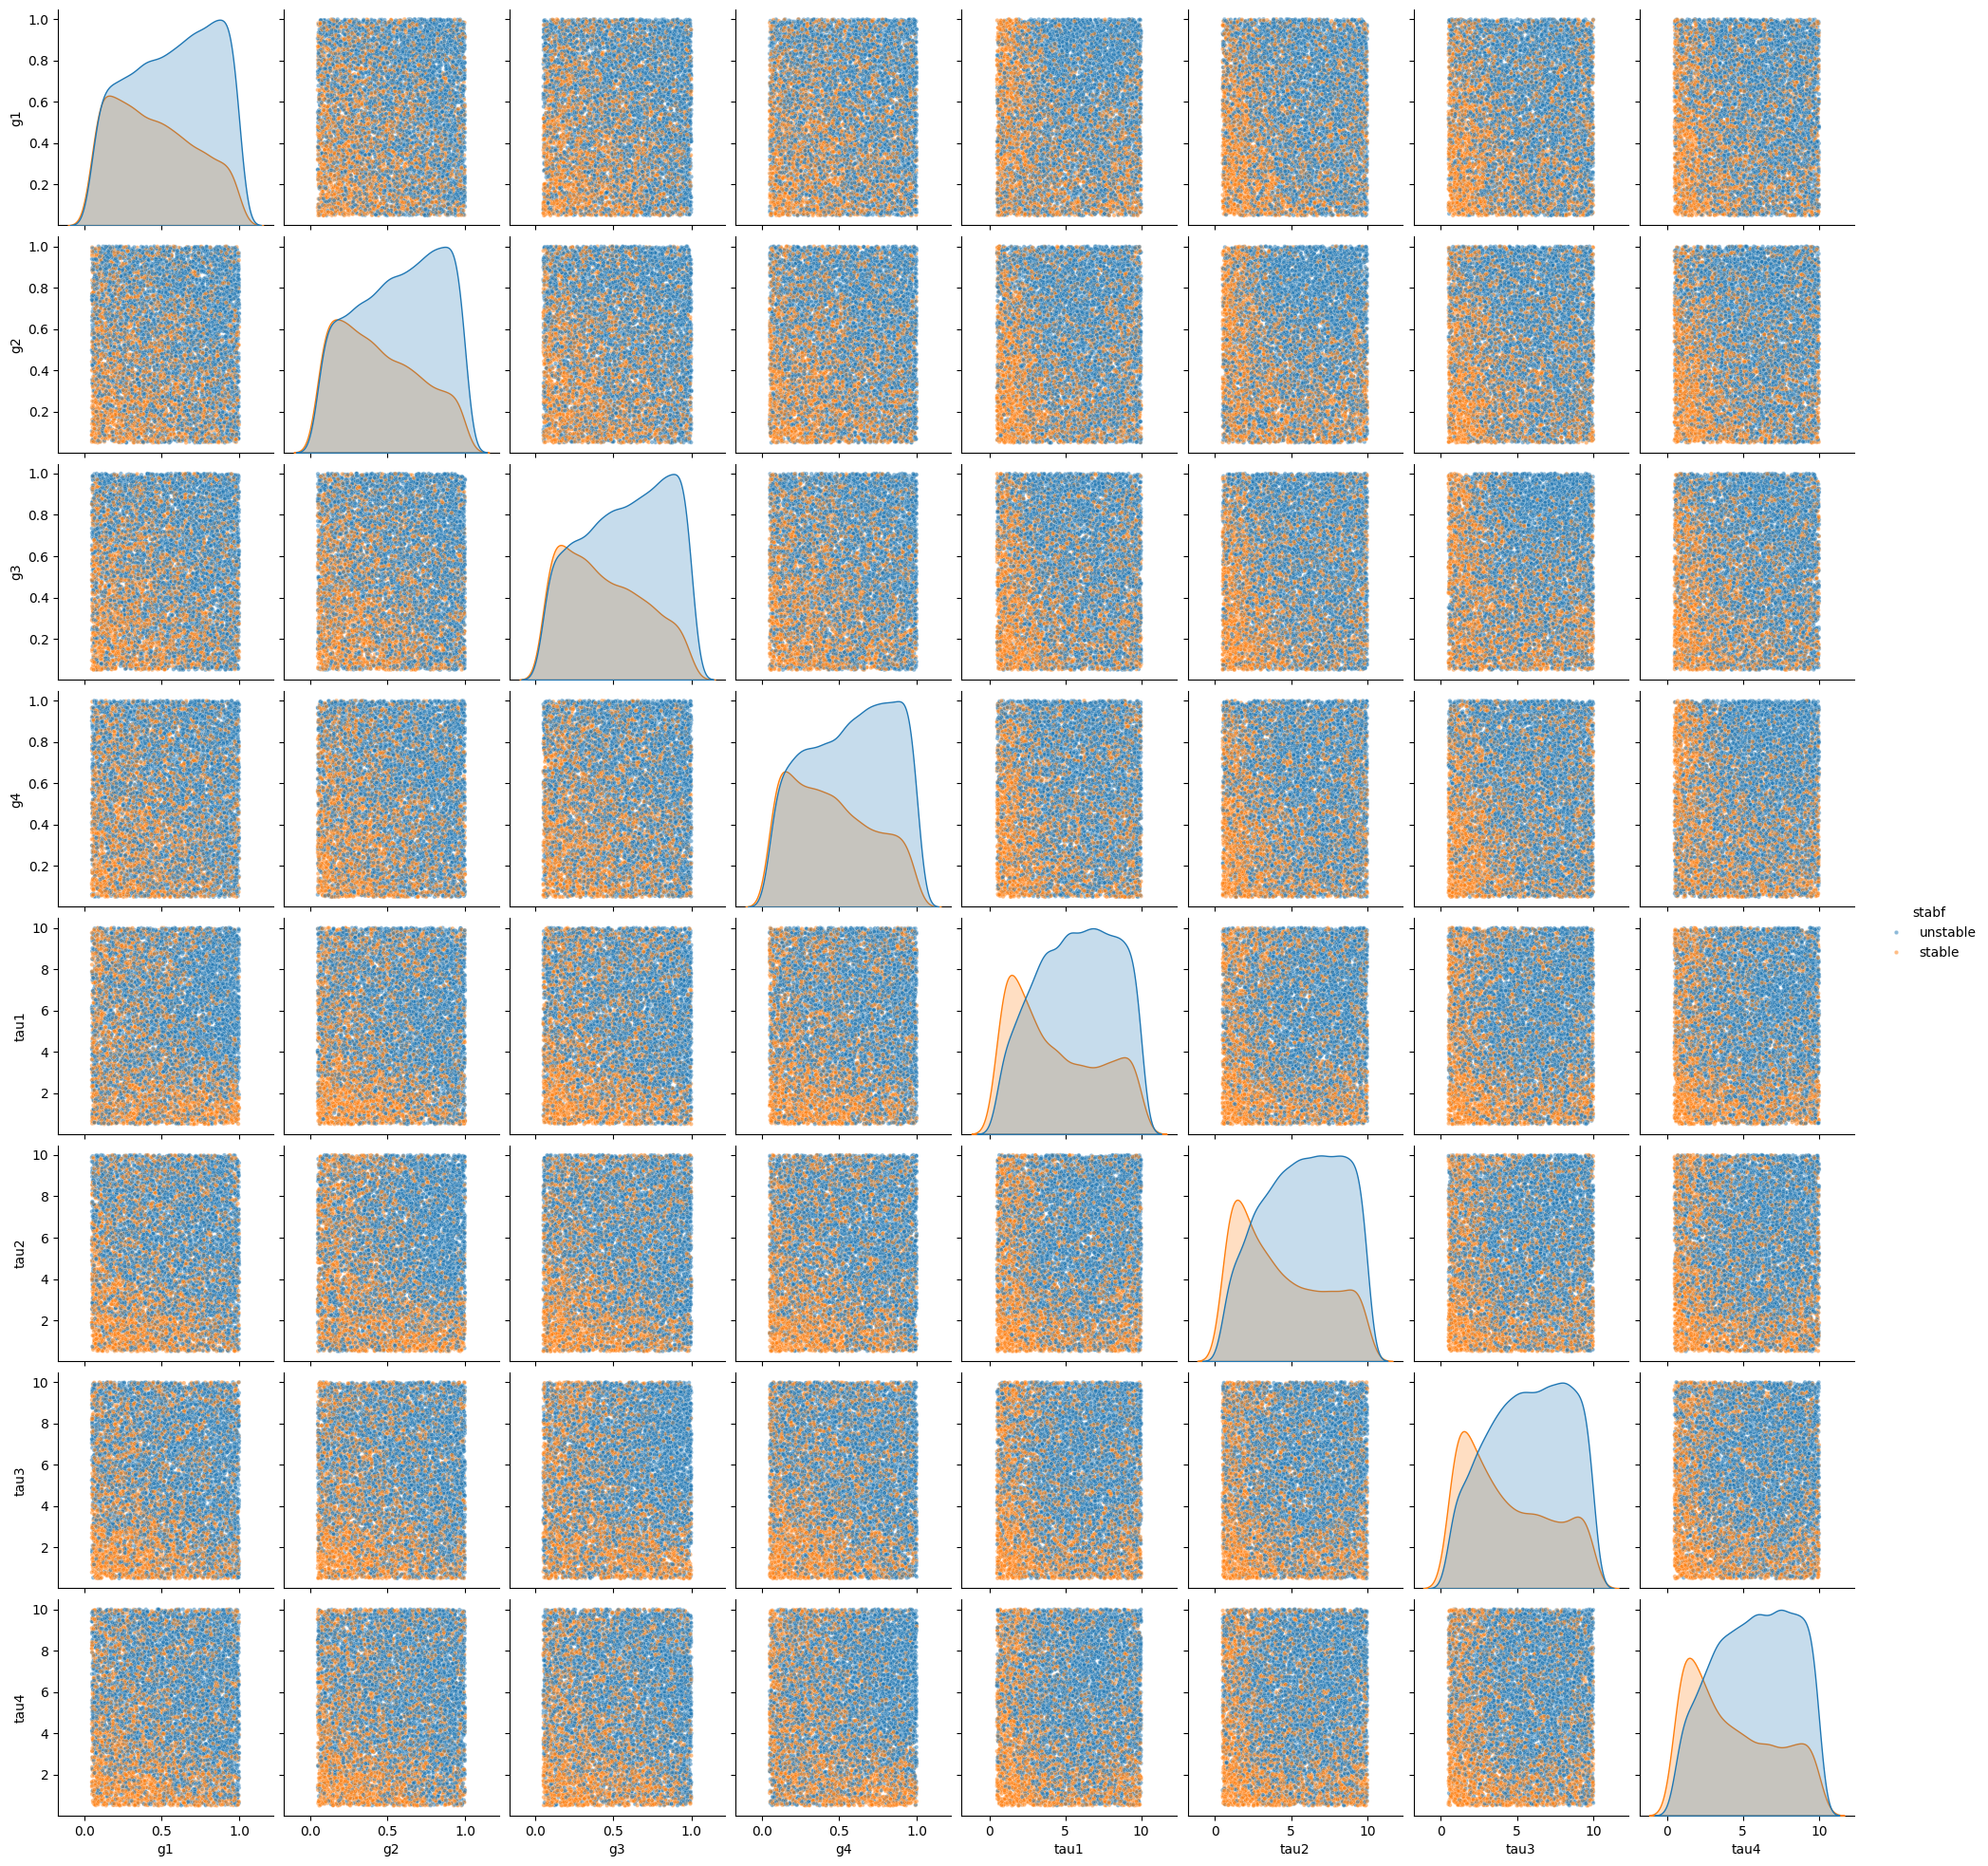

In [ ]:
selected_features = ['g1', 'g2', 'g3', 'g4', 'tau1', 'tau2','tau3', 'tau4', 'stabf']

pairplot_data = data[selected_features]

sns.pairplot(data=pairplot_data, hue='stabf', plot_kws={'alpha': 0.5, 's': 10})
plt.show()

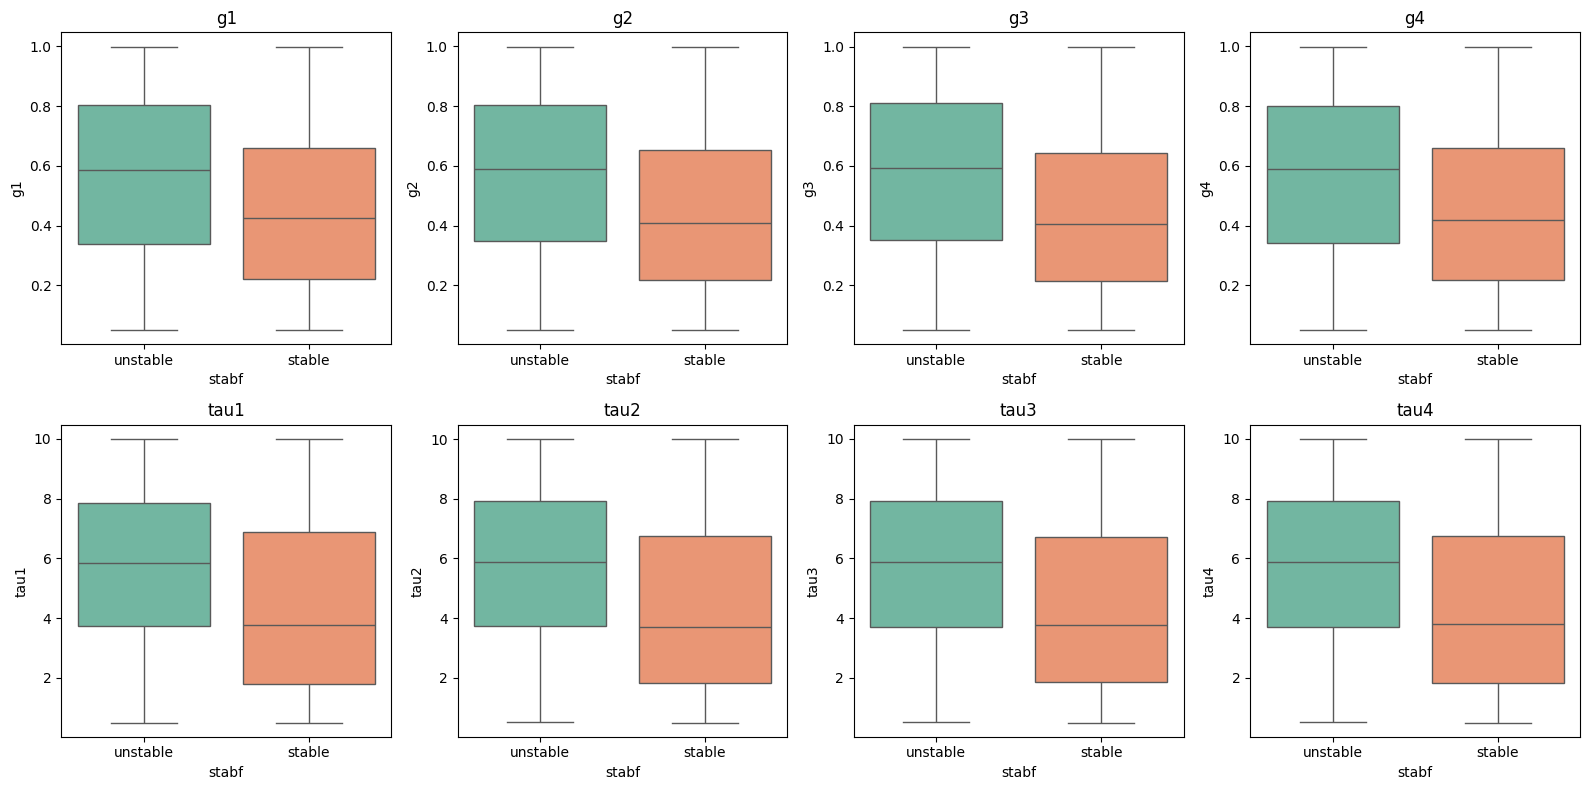

In [ ]:
selected_features = ['g1', 'g2', 'g3', 'g4', 'tau1', 'tau2', 'tau3', 'tau4']
target = 'stabf'

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

# boxplot for each feature
for i, feature in enumerate(selected_features):
    sns.boxplot(x=target, y=feature, data=data, ax=axes[i], palette='Set2',hue='stabf')
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(model, X_test, y_test, label="", color="blue"):
    y_score = model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:13:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
Accuracy: 0.9997387669801463
[[1913    1]
 [   0 1914]]
              precision    recall  f1-score   support

      stable       1.00      1.00      1.00      1914
    unstable       1.00      1.00      1.00      1914

    accuracy                           1.00      3828
   macro avg       1.00      1.00      1.00      3828
weighted avg       1.00      1.00      1.00      3828



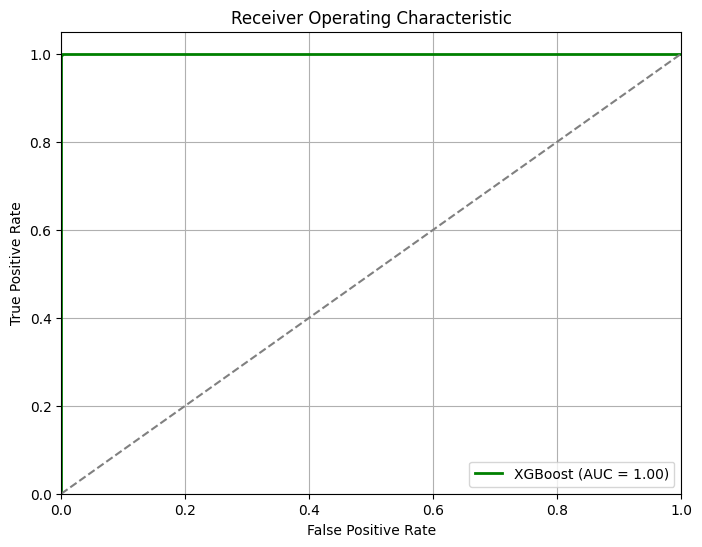

In [ ]:
# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=500, learning_rate=0.1, max_depth=6,
    random_state=42, use_label_encoder=False, eval_metric='logloss'
)

# Train XGBoost
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print("=== XGBoost ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# ROC Curve for XGBoost
plot_roc(xgb_model, X_test, y_test, "XGBoost", "green")


=== Bagging SVC ===
Accuracy: 0.8074712643678161
[[1569  345]
 [ 392 1522]]
              precision    recall  f1-score   support

      stable       0.80      0.82      0.81      1914
    unstable       0.82      0.80      0.81      1914

    accuracy                           0.81      3828
   macro avg       0.81      0.81      0.81      3828
weighted avg       0.81      0.81      0.81      3828



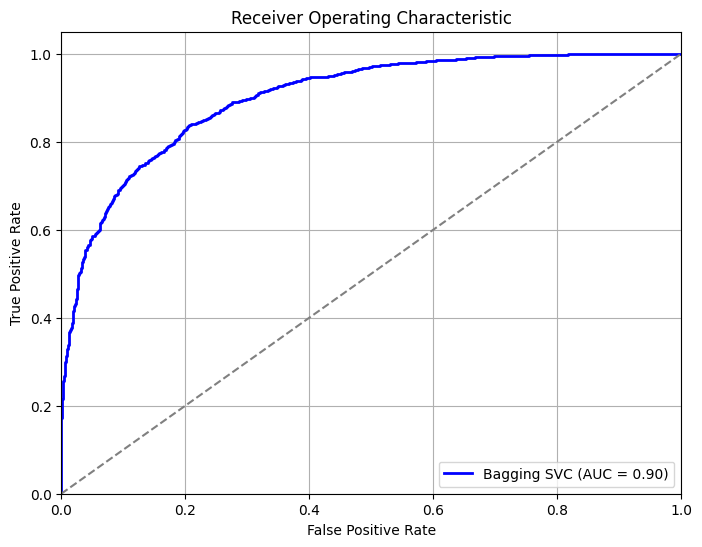

In [ ]:
# Bagging SVC model
from sklearn.ensemble import BaggingClassifier

svc_base = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svc_model = BaggingClassifier(
    estimator=svc_base, n_estimators=10, max_samples=0.1,
    n_jobs=-1, random_state=42
)

# Train Bagging SVC
svc_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svc = svc_model.predict(X_test)
print("\n=== Bagging SVC ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc, target_names=le.classes_))

# ROC Curve for Bagging SVC
plot_roc(svc_model, X_test, y_test, "Bagging SVC", "blue")



=== Naive Bayes ===
Accuracy: 0.9783176593521421
[[1893   21]
 [  62 1852]]
              precision    recall  f1-score   support

      stable       0.97      0.99      0.98      1914
    unstable       0.99      0.97      0.98      1914

    accuracy                           0.98      3828
   macro avg       0.98      0.98      0.98      3828
weighted avg       0.98      0.98      0.98      3828



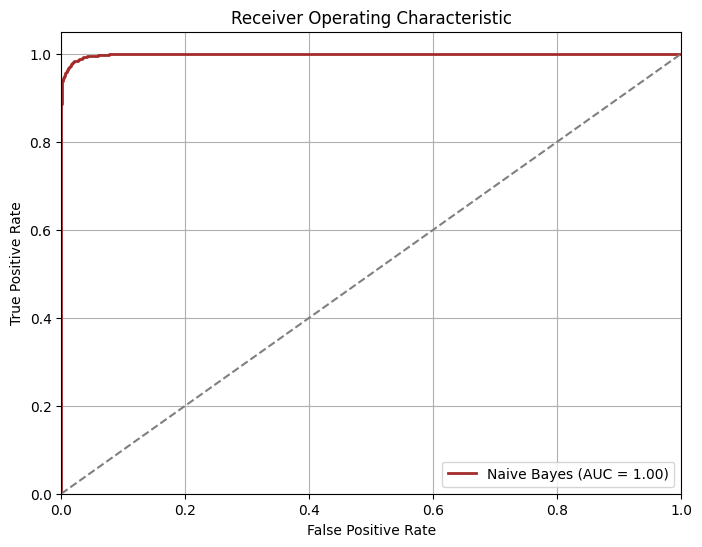

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes
nb_model = GaussianNB()

# Train and evaluate
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("\n=== Naive Bayes ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

# Plot ROC
plot_roc(nb_model, X_test, y_test, "Naive Bayes", "brown")



=== Logistic Regression ===
Accuracy: 0.8962904911180773
[[1741  173]
 [ 224 1690]]
              precision    recall  f1-score   support

      stable       0.89      0.91      0.90      1914
    unstable       0.91      0.88      0.89      1914

    accuracy                           0.90      3828
   macro avg       0.90      0.90      0.90      3828
weighted avg       0.90      0.90      0.90      3828



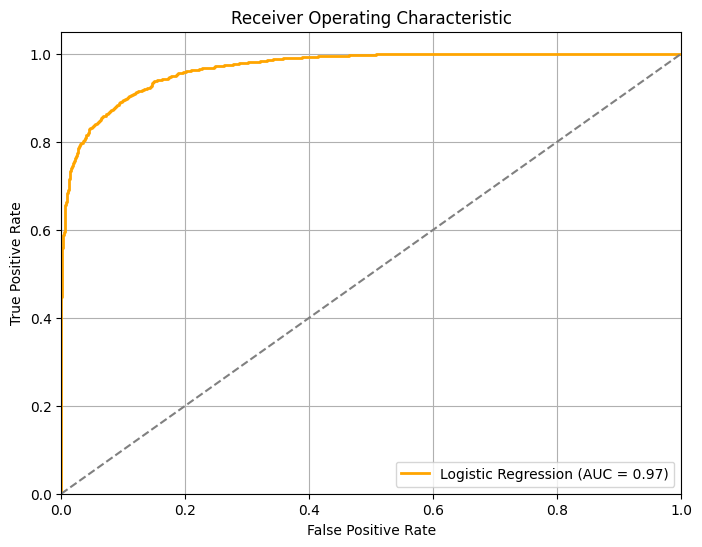

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg, target_names=le.classes_))

# Plot ROC
plot_roc(logreg_model, X_test, y_test, "Logistic Regression", "orange")



=== K-Nearest Neighbors ===
Accuracy: 0.8153082549634274
[[1676  238]
 [ 469 1445]]
              precision    recall  f1-score   support

      stable       0.78      0.88      0.83      1914
    unstable       0.86      0.75      0.80      1914

    accuracy                           0.82      3828
   macro avg       0.82      0.82      0.81      3828
weighted avg       0.82      0.82      0.81      3828



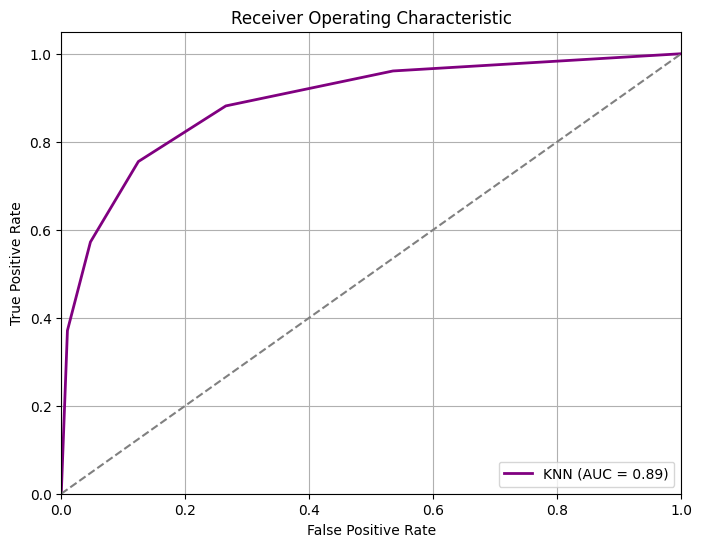

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train and evaluate
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("\n=== K-Nearest Neighbors ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

# Plot ROC
plot_roc(knn_model, X_test, y_test, "KNN", "purple")


=== Quadratic Discriminant Analysis ===
Accuracy: 0.9728317659352143
[[1839   75]
 [  29 1885]]
              precision    recall  f1-score   support

      stable       0.98      0.96      0.97      1914
    unstable       0.96      0.98      0.97      1914

    accuracy                           0.97      3828
   macro avg       0.97      0.97      0.97      3828
weighted avg       0.97      0.97      0.97      3828



/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


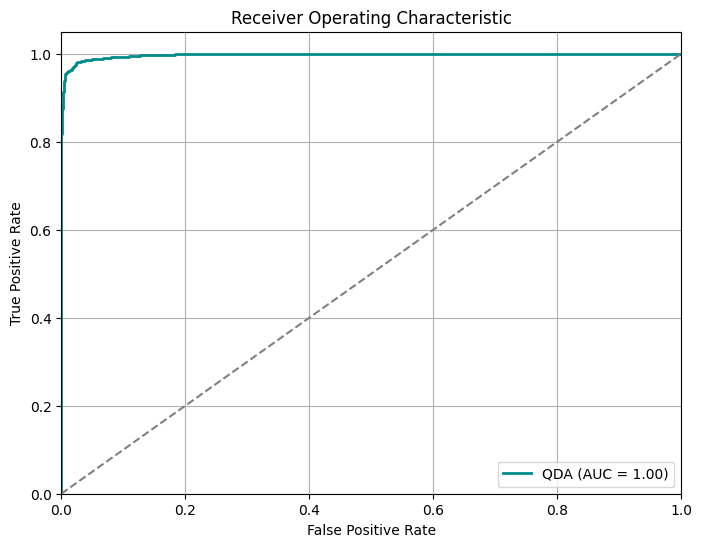

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# QDA Model
qda_model = QuadraticDiscriminantAnalysis()

# Train and evaluate
qda_model.fit(X_train, y_train)
y_pred_qda = qda_model.predict(X_test)

print("\n=== Quadratic Discriminant Analysis ===")
print("Accuracy:", accuracy_score(y_test, y_pred_qda))
print(confusion_matrix(y_test, y_pred_qda))
print(classification_report(y_test, y_pred_qda, target_names=le.classes_))

# Plot ROC
plot_roc(qda_model, X_test, y_test, "QDA", "darkcyan")


=== Linear Discriminant Analysis ===
Accuracy: 0.9584639498432602
[[1914    0]
 [ 159 1755]]
              precision    recall  f1-score   support

      stable       0.92      1.00      0.96      1914
    unstable       1.00      0.92      0.96      1914

    accuracy                           0.96      3828
   macro avg       0.96      0.96      0.96      3828
weighted avg       0.96      0.96      0.96      3828



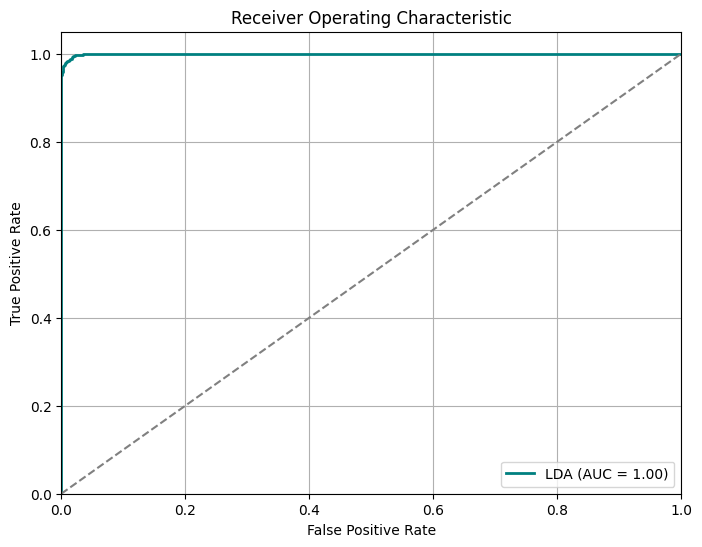

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA Model
lda_model = LinearDiscriminantAnalysis()

# Train and evaluate
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)

print("\n=== Linear Discriminant Analysis ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print(confusion_matrix(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda, target_names=le.classes_))

# Plot ROC
plot_roc(lda_model, X_test, y_test, "LDA", "teal")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Collect all model predictions
model_outputs = {
    "XGBoost": y_pred_xgb,
    "Bagging SVC": y_pred_svc,
    "Logistic Regression": y_pred_logreg,
    "KNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "LDA": y_pred_lda,
    "QDA": y_pred_qda,
}

# Compute evaluation metrics
metrics_data = {
    "Algorithm": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 score": []
}

for name, preds in model_outputs.items():
    metrics_data["Algorithm"].append(name)
    metrics_data["Accuracy"].append(accuracy_score(y_test, preds))
    metrics_data["Precision"].append(precision_score(y_test, preds))
    metrics_data["Recall"].append(recall_score(y_test, preds))
    metrics_data["F1 score"].append(f1_score(y_test, preds))

# Create and display the results table
results_df = pd.DataFrame(metrics_data)
print("=== Classification Results Table ===")
print(results_df)


=== Classification Results Table ===
             Algorithm  Accuracy  Precision    Recall  F1 score
0              XGBoost  0.999739   0.999478  1.000000  0.999739
1          Bagging SVC  0.807471   0.815212  0.795193  0.805078
2  Logistic Regression  0.896290   0.907139  0.882968  0.894890
3                  KNN  0.815308   0.858586  0.754963  0.803447
4          Naive Bayes  0.978318   0.988788  0.967607  0.978083
5                  LDA  0.958464   1.000000  0.916928  0.956664
6                  QDA  0.972832   0.961735  0.984848  0.973154


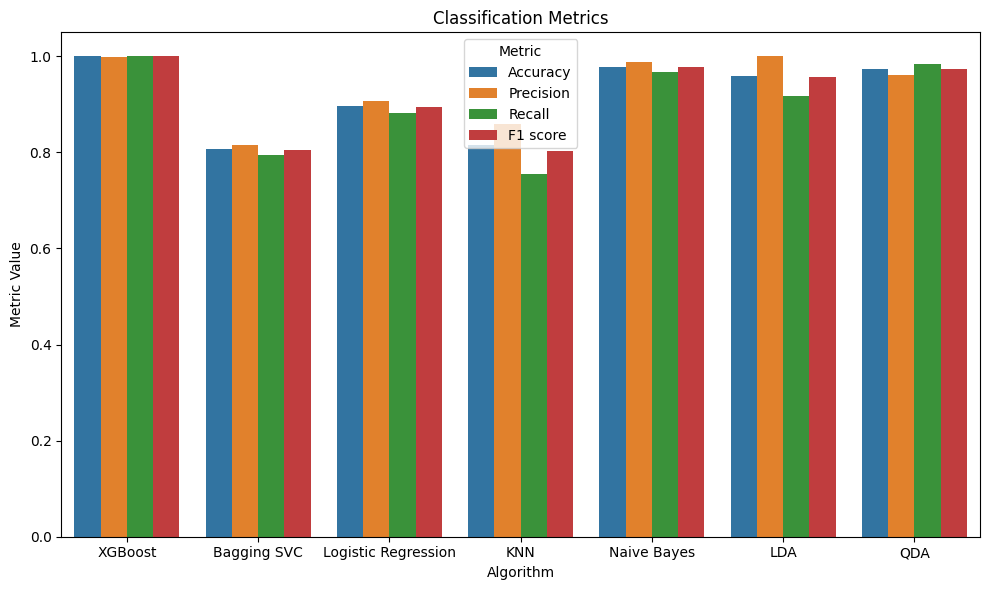

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Melt the DataFrame for easier plotting
melted_df = results_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x='Algorithm', y='Value', hue='Metric')

plt.title('Classification Metrics')
plt.xlabel('Algorithm')
plt.ylabel('Metric Value')

plt.legend(title='Metric')
plt.tight_layout()
plt.show()


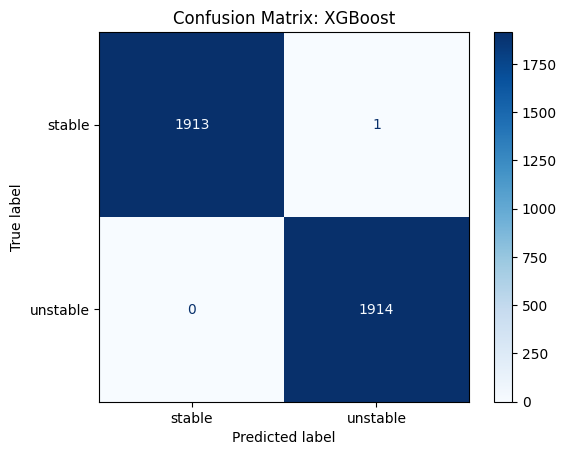

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix: XGBoost")
plt.show()


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# === Base Regressors ===
catboost_model = CatBoostRegressor(verbose=0, learning_rate=0.12, depth=7, iterations=2300)
xgb_model = XGBRegressor(learning_rate=0.15, max_depth=8, n_estimators=2600, verbosity=0)
lgbm_model = LGBMRegressor(learning_rate=0.176, max_depth=9, n_estimators=2700)

# === Stacking Regressor ===
stack_model = StackingRegressor(
    estimators=[
        ('catboost', catboost_model),
        ('xgboost', xgb_model),
        ('lightgbm', lgbm_model)
    ],
    final_estimator=Ridge(),
    passthrough=True
)

# Train
stack_model.fit(X_train, y_train)

# Predict
y_pred_stack = stack_model.predict(X_test)




Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Metrics
print("=== Stacking Regressor ===")
print("R2 Score:", r2_score(y_test, y_pred_stack))
print("RMSE:", mean_squared_error(y_test, y_pred_stack))
print("MAE:", mean_absolute_error(y_test, y_pred_stack))

=== Stacking Regressor ===
R2 Score: 0.999996328115246
RMSE: 9.179711885124861e-07
MAE: 0.00032653908688330034


In [ ]:
# === Voting Regressor ===
voting_model = VotingRegressor(estimators=[
    ('catboost', catboost_model),
    ('xgboost', xgb_model),
    ('lightgbm', lgbm_model)
])

# Train
voting_model.fit(X_train, y_train)

# Predict
y_pred_vote = voting_model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 8932, number of used features: 13
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
# Metrics
print("\n=== Voting Regressor ===")
print("R2 Score:", r2_score(y_test, y_pred_vote))
print("RMSE:", mean_squared_error(y_test, y_pred_vote))
print("MAE:", mean_absolute_error(y_test, y_pred_vote))


=== Voting Regressor ===
R2 Score: 0.9997796470785609
RMSE: 5.5088230359769744e-05
MAE: 0.0008007653811365854


In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Initialize model
catboost_model = CatBoostRegressor(
    verbose=0,
    learning_rate=0.12,
    depth=7,
    iterations=2300,
    random_state=42
)

# Train
catboost_model.fit(X_train, y_train)

# Predict
y_pred_cb = catboost_model.predict(X_test)

# Evaluate
print("=== CatBoost Regressor ===")
print("R2 Score:", r2_score(y_test, y_pred_cb))
print("RMSE:", mean_squared_error(y_test, y_pred_cb))
print("MAE:", mean_absolute_error(y_test, y_pred_cb))


=== CatBoost Regressor ===
R2 Score: 0.9998889248737843
RMSE: 2.7768781553905563e-05
MAE: 0.0018679848575691694


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# Create the metrics DataFrame using np.sqrt() for RMSE
results_df = pd.DataFrame({
    'Algorithm': ['CatBoost', 'Stacking', 'Voting'],
    'R2 Score': [
        r2_score(y_test, y_pred_cb),
        r2_score(y_test, y_pred_stack),
        r2_score(y_test, y_pred_vote)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_cb)),
        np.sqrt(mean_squared_error(y_test, y_pred_stack)),
        np.sqrt(mean_squared_error(y_test, y_pred_vote))
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_cb),
        mean_absolute_error(y_test, y_pred_stack),
        mean_absolute_error(y_test, y_pred_vote)
    ]
})


<ipython-input-30-c7c83e79fc96>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Algorithm', y='R2 Score', palette='magma')


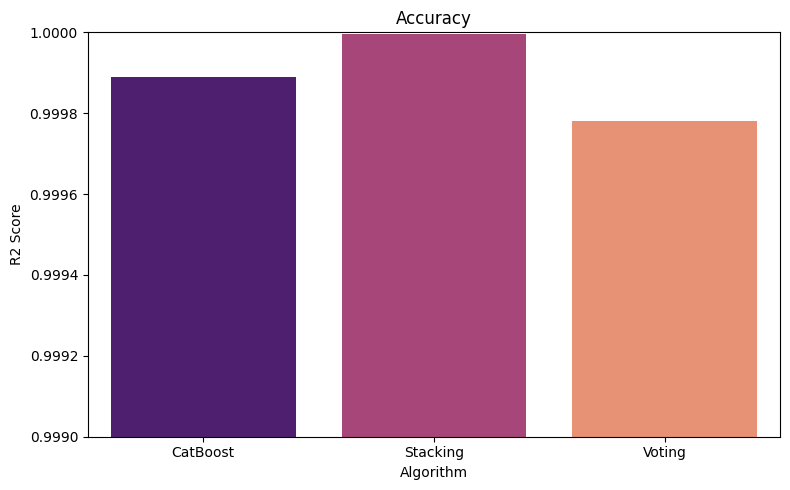

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Algorithm', y='R2 Score', palette='magma')

plt.title('Accuracy')
plt.ylim(0.999,1)
plt.xlabel('Algorithm')
plt.ylabel('R2 Score')
plt.tight_layout()
plt.show()

<ipython-input-31-b398d1187dd8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Algorithm', y='MAE', palette='magma')


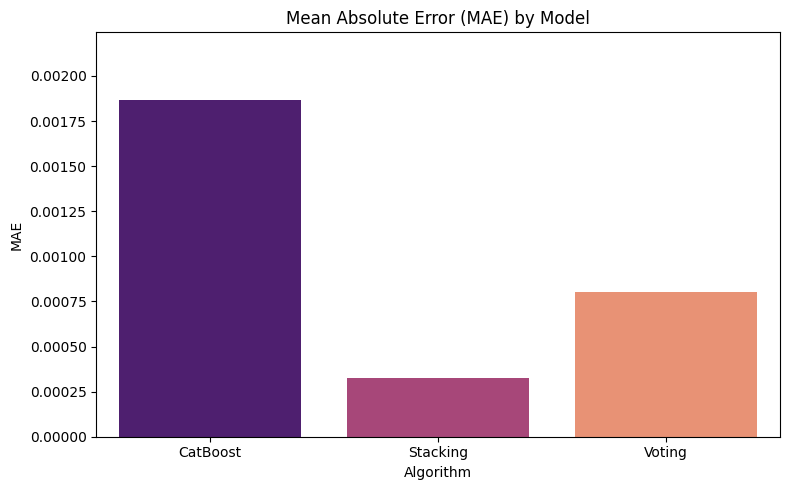

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Algorithm', y='MAE', palette='magma')

plt.title('Mean Absolute Error (MAE) by Model')
plt.ylim(0, results_df['MAE'].max() * 1.2)
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()


<ipython-input-32-84acaed6f20b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Algorithm', y='RMSE', palette='cividis')


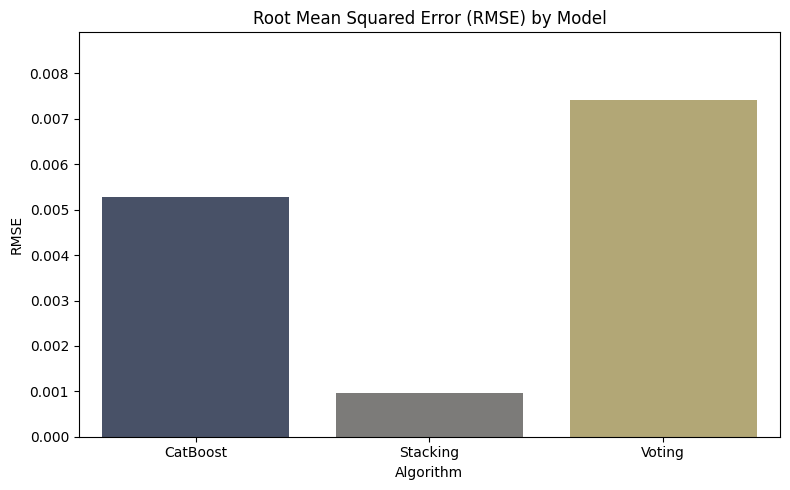

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Algorithm', y='RMSE', palette='cividis')

plt.title('Root Mean Squared Error (RMSE) by Model')
plt.ylim(0, results_df['RMSE'].max() * 1.2)
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()


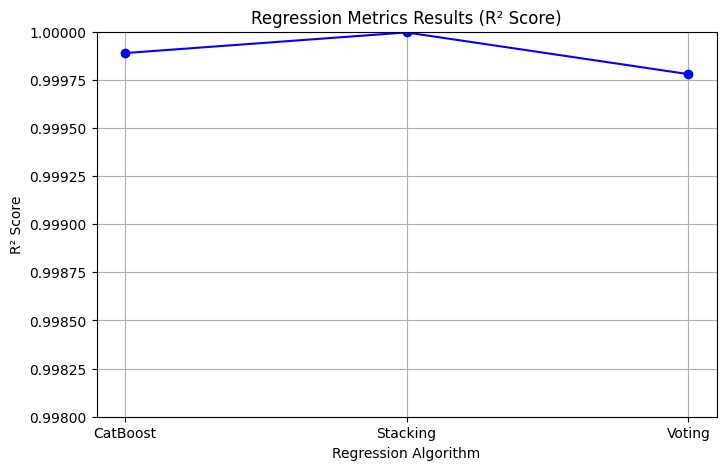

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['Algorithm'], results_df['R2 Score'], marker='o', linestyle='-', color='b')
plt.title("Regression Metrics Results (R² Score)")
plt.xlabel("Regression Algorithm")
plt.ylabel("R² Score")
plt.ylim(0.998, 1.0)
plt.grid(True)
plt.show()

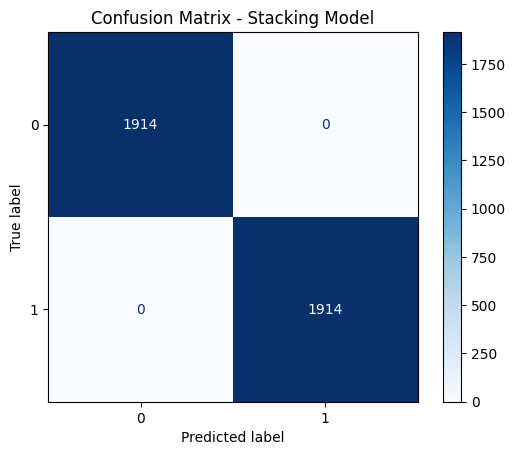

In [ ]:
y_pred_labels = (y_pred_stack >= 0.5).astype(int)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Stacking Model")
plt.show()


100%|===================| 3825/3828 [19:42<00:00]       

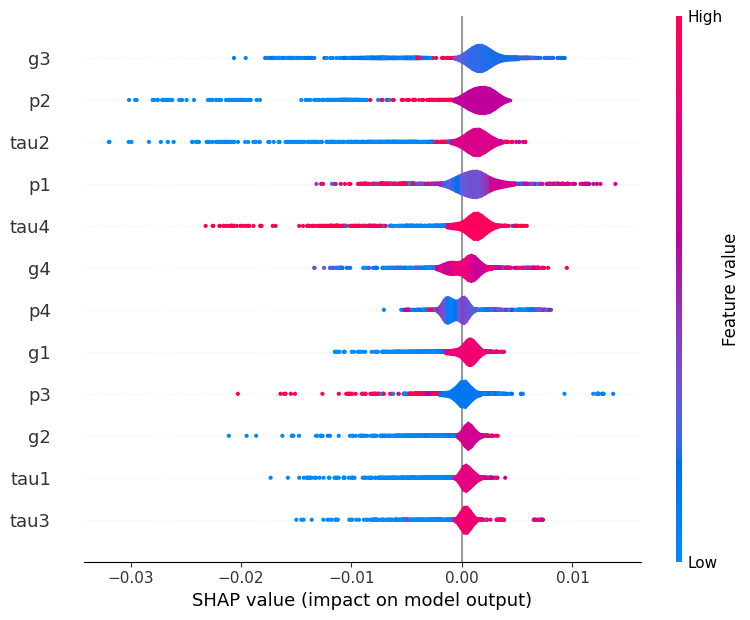

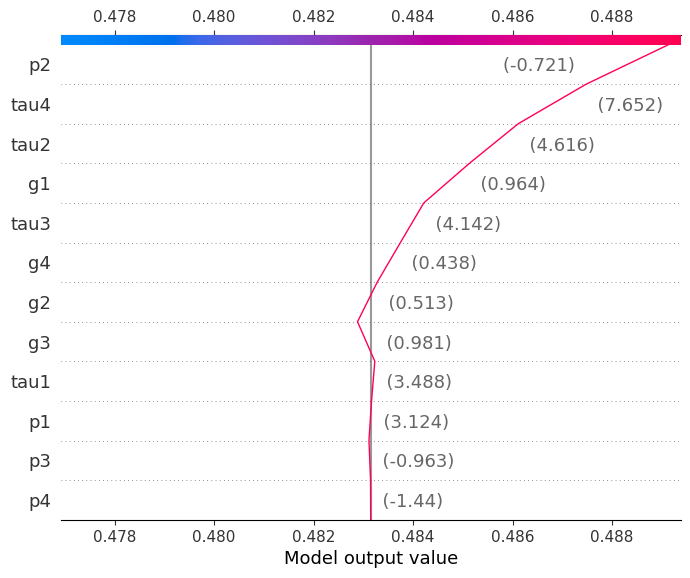

In [ ]:
import shap
import matplotlib.pyplot as plt

# Drop 'stab' from the features
X_sample_features = X_test.drop(columns=["stab"], errors="ignore")

# Create SHAP explainer
explainer = shap.Explainer(catboost_model, X_sample_features)

# Compute SHAP values
shap_values = explainer(X_sample_features, check_additivity=False)

# SHAP Summary Plot (violin-style)
shap.summary_plot(shap_values, X_sample_features, plot_type="violin")

# SHAP Decision Plot for the first instance
shap.decision_plot(
    explainer.expected_value,
    shap_values.values[0],
    features=X_sample_features.iloc[0],
    feature_names=X_sample_features.columns.tolist()
)


In [ ]:
from scipy.stats import wilcoxon
model_names = [
    "Bagging SVC",
    "Logistic Regression",
    "KNN",
    "Naive Bayes",
    "LDA",
    "QDA",
]
model_preds = {
    "Bagging SVC": y_pred_svc,
    "Logistic Regression": y_pred_logreg,
    "KNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "LDA": y_pred_lda,
    "QDA": y_pred_qda,
}
xgb_preds = y_pred_xgb
y_true = y_test


In [ ]:
results = []

for model, preds in model_preds.items():
    try:
        stat, p = wilcoxon(preds, xgb_preds)
    except ValueError:
        stat, p = np.nan, np.nan
    results.append({'Model': model, 'Test statistic': stat, 'P-Value': p})

df_results = pd.DataFrame(results)


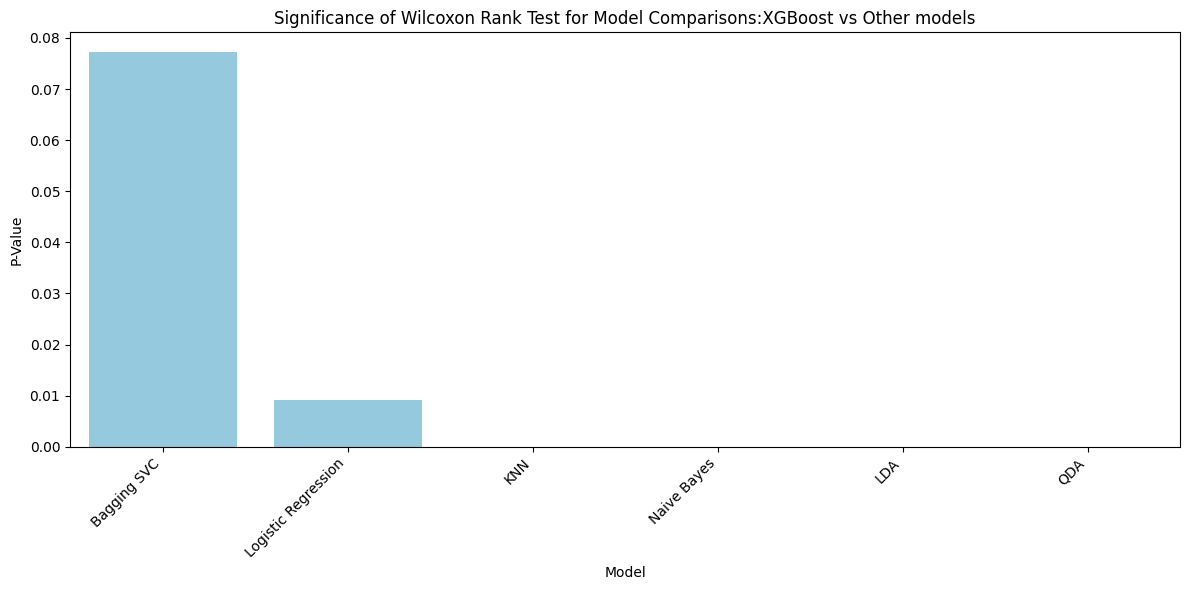

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x='Model', y='P-Value', color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("P-Value")
plt.title("Significance of Wilcoxon Rank Test for Model Comparisons:XGBoost vs Other models")
plt.tight_layout()
plt.show()


In [ ]:
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


              Model  Test statistic      P-Value
        Bagging SVC        127477.5 7.724424e-02
Logistic Regression         34513.5 9.146629e-03
                KNN         84371.0 2.804369e-18
        Naive Bayes           892.5 4.592834e-06
                LDA             0.0 1.131484e-36
                QDA          1508.0 9.250846e-06
